# Example 4: PEG-PLGA copolymers
More complicated example of a triple of monomers which generate an ensemble of copolymerizable fragments, which react via the same ester pathway

## Output config

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, enable_kekulized_drawing


# Molecule drawing settings
MOL_IMG_WIDTH  : int = 400
MOL_IMG_HEIGHT : int = 300
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

enable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Define chemically-complete monomer "feedstocks"

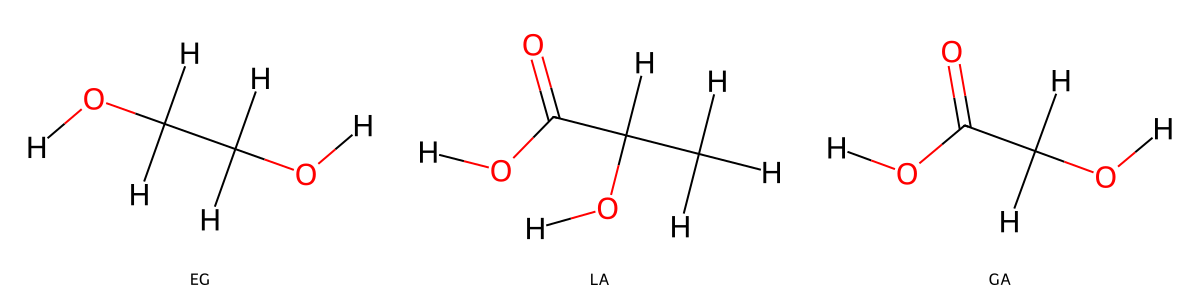

In [2]:
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.rdmolops import SANITIZE_ALL, AROMATICITY_MDL
from polymerist.rdutils.sanitization import explicit_mol_from_SMILES, Smiles


monomer_smiles : dict[str, Smiles] = {
    'EG' : 'OCCO',        # ethylene glycol
    'LA' : 'OC(=O)C(C)O', # lactic acid
    'GA' : 'OC(=O)CO',    # glycolic acid
}
monomers : dict[str, Mol] = {
    name : explicit_mol_from_SMILES(
        smiles,
        sanitize_ops=SANITIZE_ALL,
        aromaticity_model=AROMATICITY_MDL,
    )
        for name, smiles in monomer_smiles.items()
}

MolsToGridImage(monomers.values(), molsPerRow=len(monomers), subImgSize=MOL_IMG_SIZE, legends=monomers.keys())

## Define reaction template for polymerization reaction

### Assemble reaction from target functional groups (in this case a hydroxyl and a carboxylic acid)
In this case, one needs to be careful in how the hydroxyl moiety is specified, as the naive definition ("*-O-[H]") is _also_ a substructure of the carboxyl group   
The reactive functional group templates ReactionAssembler requires are defined by SMARTS queries, allowing one to perform more complex substructure queries in cases like this

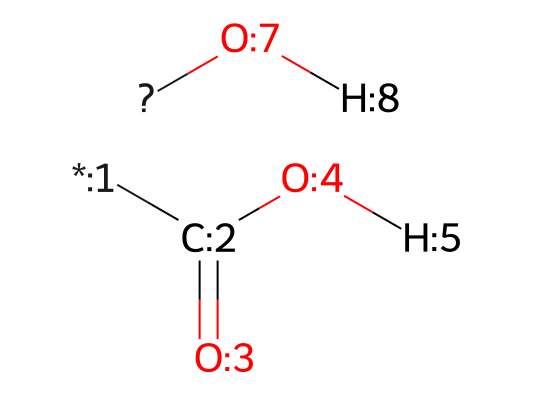

In [3]:
from rdkit.Chem.rdmolfiles import MolFromSmarts, MolToSmiles
from polymerist.rdutils.reactions import ReactionAssembler


# note carefully that a "*" site is NOT present in the hydroxyl group definition, with a "non-carbonyl" query taking its place instead
# a "*" matches to ANY atom without restriction, which is not what we want here
assem = ReactionAssembler(
    reactive_groups=[
        MolFromSmarts('*-C(=O)-O-[H]'),      # carboxyl group (defined as one would expect)
        MolFromSmarts('[!$([#6]=O)]-O-[H]'), # hydroxyl group (defined as OH specifically NOT attached to a carbonyl carbon)
    ],
    byproducts=[MolFromSmarts('[H]-[O]-[H]')], # eject and unmap water byproduct
    rxn_name='polyester condensation',
)
display(assem.reactants)

INFO:polymerist.rdutils.bonding.permutation:8 --x-> 7


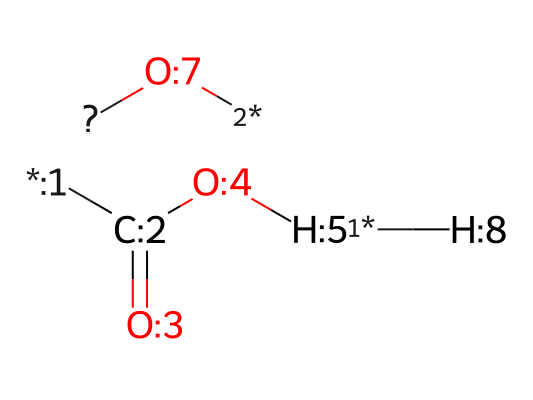

INFO:polymerist.rdutils.bonding.permutation:2 --x-> 4


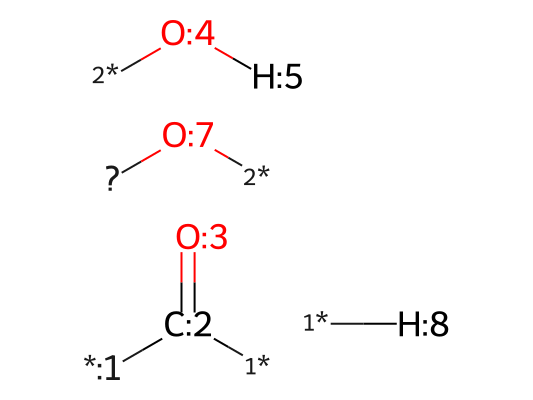

INFO:polymerist.rdutils.bonding.permutation:8 ----> 4


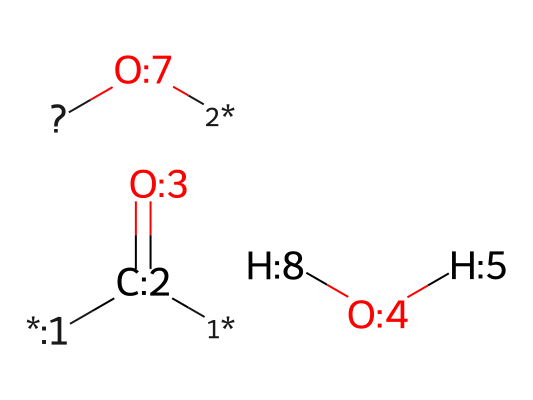

INFO:polymerist.rdutils.bonding.permutation:2 ----> 7


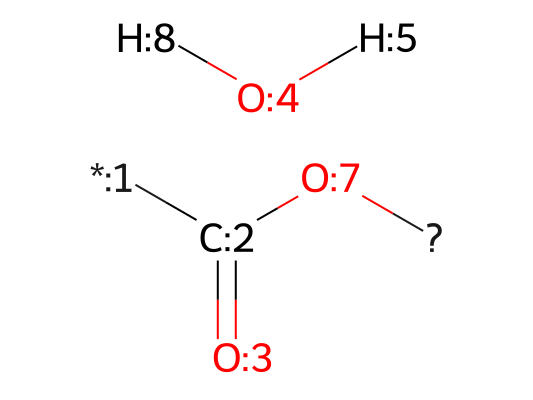

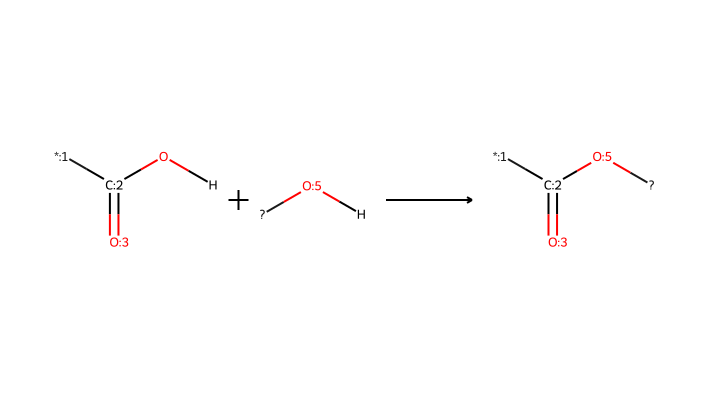

In [4]:
assem.bond_derangement = {
    8 : (7, 4), # H:8, which was connected to O:7, should reconnect to O:4
    2 : (4, 7), # C:2, which was connected to O:4, should reconnect to O:7
} # note that this forms a closed bond cycle, since atoms 2 and 8 each gain and lose 1 bond, respectively, amounting to no net valence change
## Also note that the seemingly-equivalent cycle {
#   7 : (6, 5),
#   4 : (5, 6),
# }
## is not valid, as one of the intermediate fragments consists of two linkers bonded to one another ("neutronium"), which acts as an "identity" element when splicing bonds

rxn = assem.assemble_rxn(show_steps=True)
display(rxn)

### Export reaction for re-use

In [5]:
from polymerist.genutils.fileutils import assemble_path


rxn_smarts = rxn.to_smarts()
rxn_path = assemble_path('rxn_demo_files/rxns', prefix=rxn.rxnname, extension='rxn')
rxn_path.parent.mkdir(exist_ok=True, parents=True)
rxn.to_rxnfile(rxn_path)

## Enumerate all possible repeat unit fragments from monomers and reaction template

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 5 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 3 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 3 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 3 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 3 reaction step(s) or more


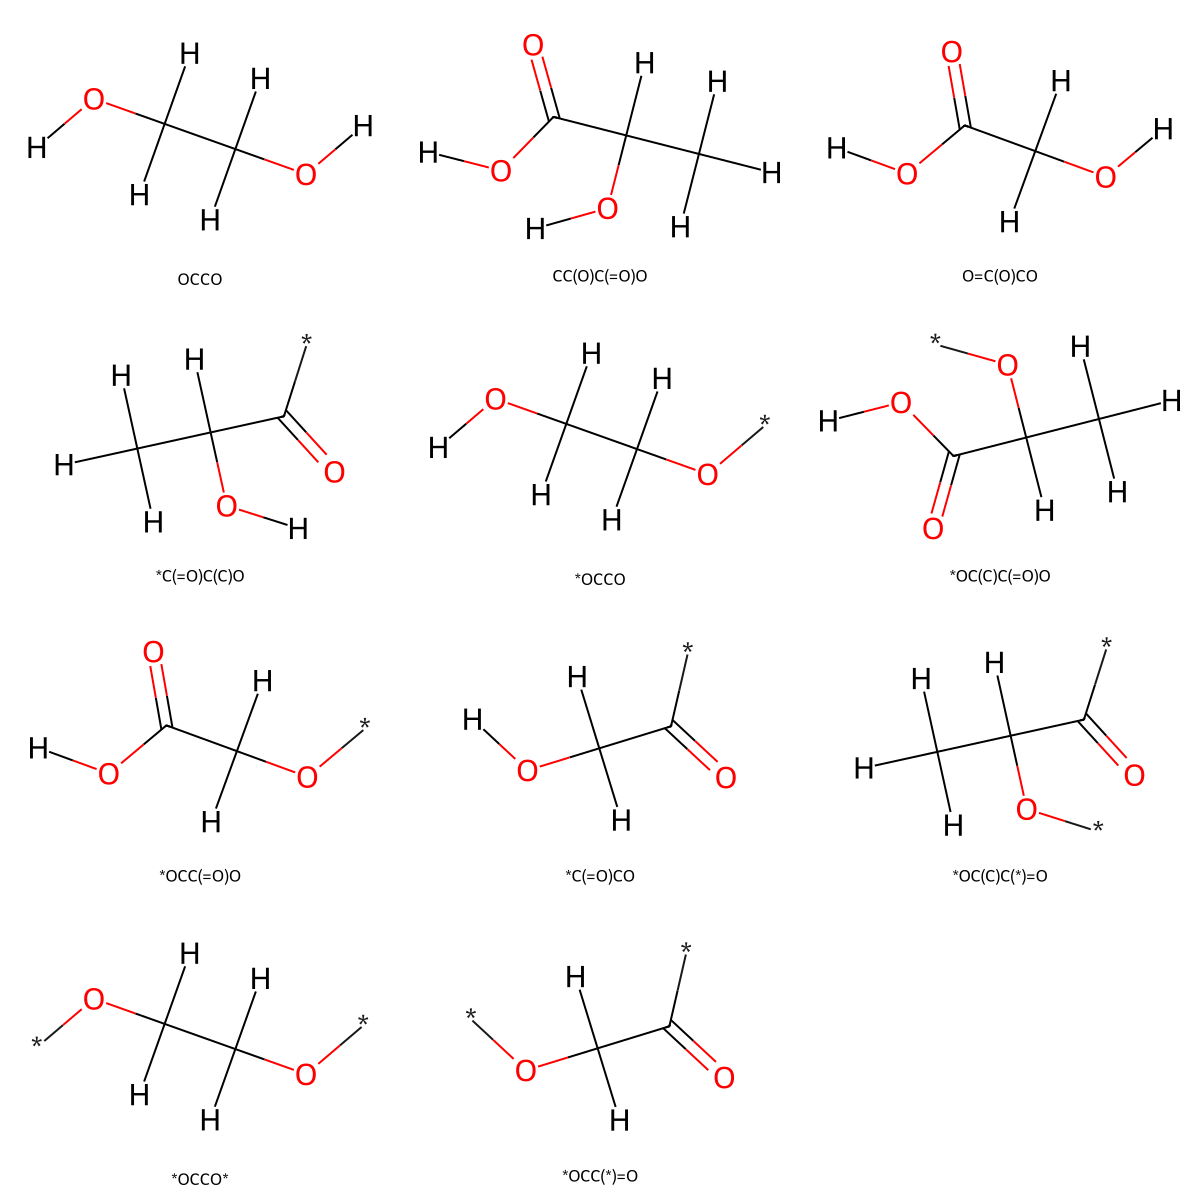

In [6]:
from polymerist.rdutils.reactions import AnnotatedReaction
from polymerist.rdutils.reactions import PolymerizationReactor, CutMinimumCostBondsStrategy


reactor = PolymerizationReactor(
    rxn_schema=AnnotatedReaction.from_smarts(rxn_smarts),
    fragment_strategy=CutMinimumCostBondsStrategy()
)
fragments = reactor.propagate_pooled(
    monomers.values(),
    allow_resampling=True, # allow resampling of monomers to produce more fragments
    sanitize_ops=SANITIZE_ALL,
    aromaticity_model=AROMATICITY_MDL,
    clear_dummy_labels=True,
)
MolsToGridImage(fragments.values(), molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=fragments.keys())

### Generate monomer specification-compliant SMARTS with informative names for each non-monomer fragment
This fragment compilation routine is similar to that of the prior examples, but includes a more complex naming procedure;  

Namely, the "parent" monomer super structure for each fragment is identified, the functionality of each fragment is determined,  
AND a sufixx for multiples of the same (parent, functionality) pair are autoamtically deduced

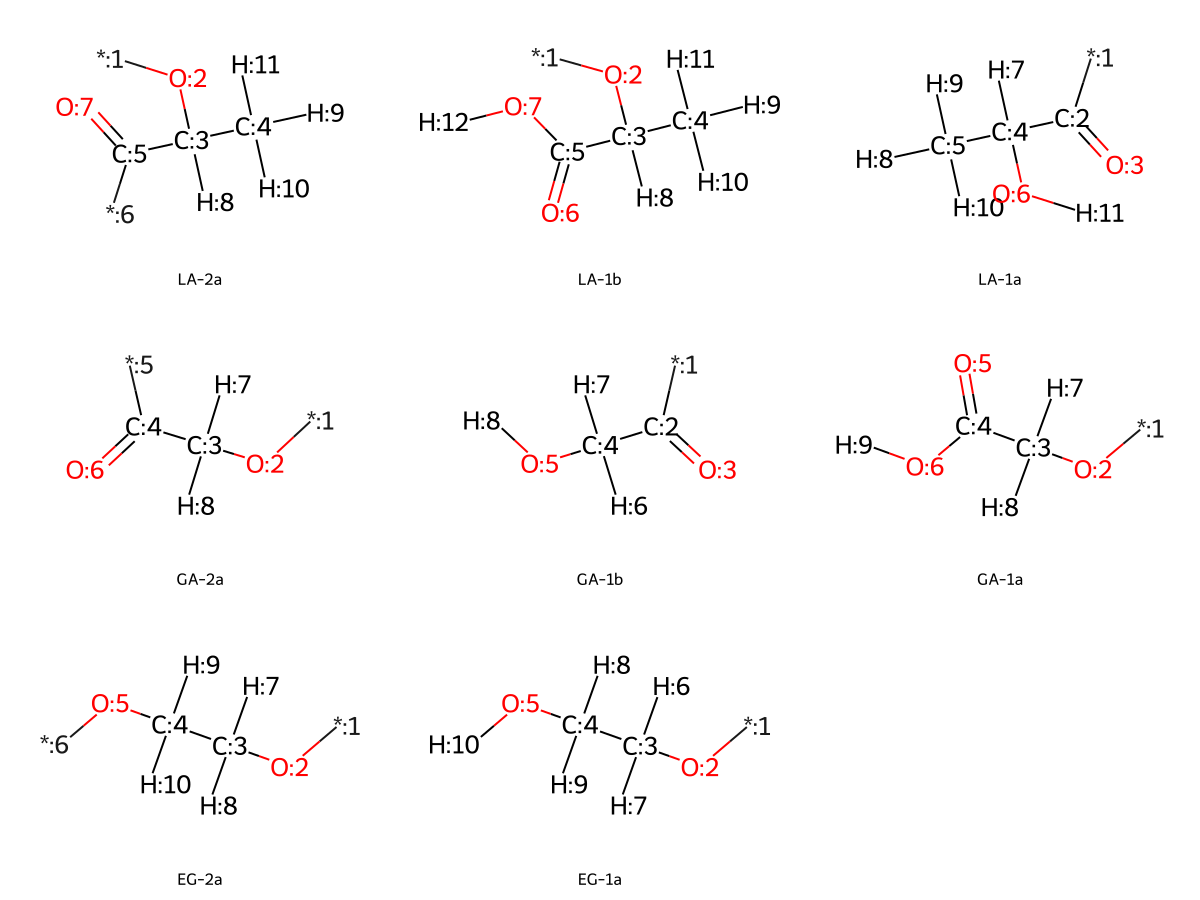

In [7]:
from string import ascii_lowercase
from collections import defaultdict, Counter

from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports
from polymerist.genutils.iteration import sort_dict_by_keys


named_fragments : dict[str, Smiles] = {}
fragment_name_modifiers = defaultdict(Counter) # keeps track of how many times each (monomer name, functionality) pair is found to generate distinguishing suffixes
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    query_smiles = MolToSmiles(fragment_mol, allHsExplicit=True, allBondsExplicit=True) # canonical SMILES is missing much of the chemical info we need to obtain an explicit substructure match
    query_mol = MolFromSmarts(query_smiles) # important! need to makes SMARTS-based query mol to check for substructure - ports on returned SMILES-based mols are not treated correctly as wild-type atoms
    parent_mol_name = '-'.join(name for name, monomer in monomers.items() if monomer.HasSubstructMatch(query_mol))
    suffix = ascii_lowercase[fragment_name_modifiers[parent_mol_name][functionality]]
    
    named_fragments[f'{parent_mol_name}-{functionality}{suffix}'] = canon_smiles
    fragment_name_modifiers[parent_mol_name][functionality] += 1
    
monogrp = MonomerGroup(sort_dict_by_keys(named_fragments, reverse=True)) # sorting is not necessary for any functionality, but groups like fragments together for viewing 
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

### Generate monomer specification-compliant SMARTS with informative names for each non-monomer fragment

## Use fragments to assemble a polymer

In [8]:
from polymerist.polymers.building import build_linear_polymer


# these are for you to configure
n_monomers : int = 80
do_energy_min : bool = False # if enable, will yield more physically-plausible structure, at the cost of slower structure output

monogrp.term_orient = {
    'head' : 'LA-1a',
    'tail' : 'EG-1a',
}
chain = build_linear_polymer(
    monomers=monogrp,
    sequence='ABCBB',
    n_monomers=n_monomers,
    allow_partial_sequences=True, # relax requirement of having a whole-number of repetitions of the sequence to allow any number of monomers
    energy_minimize=do_energy_min,
)
chain.visualize()

[12:24:21] WARNING: not removing hydrogen atom with dummy atom neighbors
INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'LA-1a', 'tail': 'EG-1a'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "ABCBB" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 15 whole 5-sequence repeat(s) and a partial 3/5 sequence repeat, namely with the sequence [LA-1a] + 15*[ABCBB] + [ABC] + [EG-1a]
INFO:polymerist.polymers.building.linear:Registering middle monomer LA-2a (block identifier "A")
INFO:polymerist.polymers.building.linear:Registering middle monomer GA-2a (block identifier "B")
INFO:polymerist.polymers.building.linear:Registering middle monomer EG-2a (block identifier "C")
INFO:polymerist.polymers.building.linear:Registering terminal monomer LA-1a (orientation "head")
INFO:polymerist.polymers.building.linear:Registering terminal monomer EG-1a (orientation "tail")
INFO:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Export polymer structure files

In [9]:
from pathlib import Path


polymer_name : str = 'PEG-PLGA'
structures_dir = Path('rxn_demo_files/structures') / polymer_name
structures_dir.mkdir(exist_ok=True, parents=True)

### Export to SDFile

In [10]:
from rdkit.Chem.rdmolfiles import SDWriter
from polymerist.polymers.building import mbmol_to_rdmol


sdf_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='sdf')
with SDWriter(sdf_path) as writer:
    writer.write(mbmol_to_rdmol(chain))

### Export to PDB File

In [11]:
from polymerist.polymers.building import mbmol_to_openmm_pdb


pdb_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='pdb')
pdb_path.parent.mkdir(exist_ok=True, parents=True)
mbmol_to_openmm_pdb(pdb_path, chain)

### Save repeat unit fragments to disc

In [12]:
fragments_path = assemble_path('rxn_demo_files/fragments', prefix=polymer_name, extension='json')
fragments_path.parent.mkdir(exist_ok=True, parents=True)
monogrp.to_file(fragments_path)